In [1]:
import pandas as pd
df = pd.read_excel('parking_data.xlsx')
df.drop(['Schlossberg'],axis=1,inplace=True)


In [2]:
df.loc[df['Ambahnhof'] > 278, 'Ambahnhof'] = 278
df['Ambahnhof'] = df['Ambahnhof']/278
df.dtypes

Date          object
Ambahnhof    float64
dtype: object

In [3]:
df['Date']=pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
df = df.sort_values(by='Date',ascending=True)
df.head()

,Date,Ambahnhof
0,2016-06-21 08:05:46,0.140288
1,2016-06-21 08:10:44,0.122302
2,2016-06-21 08:15:09,0.107914
3,2016-06-21 08:20:02,0.104317
4,2016-06-21 08:25:04,0.104317


In [4]:
#round to hour
#df['Date'] = df['Date'].dt.floor('h')
df.head()

,Date,Ambahnhof
0,2016-06-21 08:05:46,0.140288
1,2016-06-21 08:10:44,0.122302
2,2016-06-21 08:15:09,0.107914
3,2016-06-21 08:20:02,0.104317
4,2016-06-21 08:25:04,0.104317


In [5]:
df = df.drop_duplicates(subset = "Date")
df.shape

(550177, 2)

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from prophet import Prophet
from prophet.plot import plot_plotly

In [7]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size
univariate_df = df[['Date', 'Ambahnhof']].copy()
univariate_df.columns = ['ds', 'y']


train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

467650 82527


In [8]:
# Train the model
model = Prophet(changepoint_prior_scale=0.001,interval_width = 0.9,	yearly_seasonality=True,
                weekly_seasonality= True, 
                daily_seasonality=True
)
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7k5gn_i/gmp0_jvn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt7k5gn_i/nx7r7l3s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12157', 'data', 'file=/tmp/tmpt7k5gn_i/gmp0_jvn.json', 'init=/tmp/tmpt7k5gn_i/nx7r7l3s.json', 'output', 'file=/tmp/tmpt7k5gn_i/prophet_modelqwf4yv6u/prophet_model-20221024112003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:20:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:23:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
# Calculate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

RMSE: 0.23470059790034


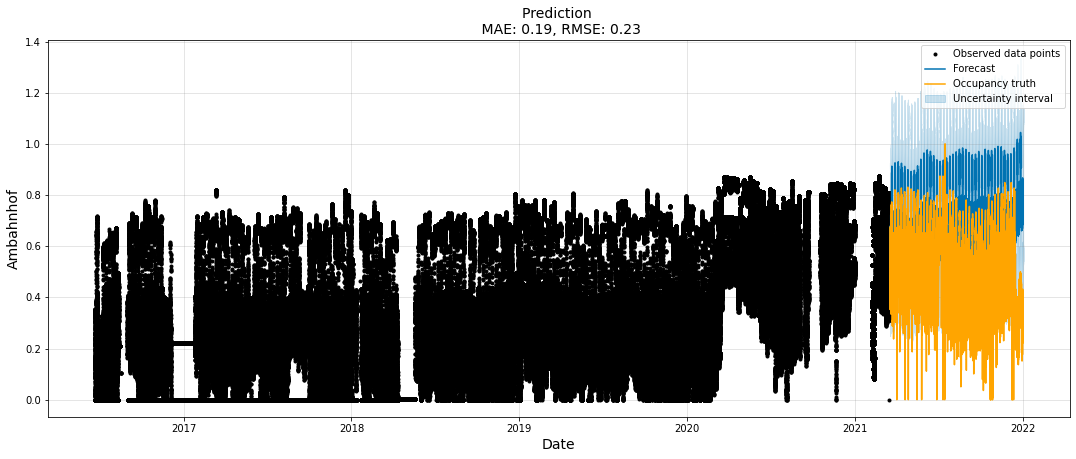

In [10]:
# Plot the forecast
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Occupancy truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Ambahnhof', fontsize=14)

plt.show()

In [1]:
from prophet.plot import plot_plotly
import matplotlib.pyplot as plt

future = model.make_future_dataframe(periods=100)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
plot_plotly(model, forecast)

NameError: ignored

In [ ]:
#Prediction

from prophet.plot import plot_plotly
import matplotlib.pyplot as plt

future = model.make_future_dataframe(periods=150)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
plot_plotly(model, forecast)